# **Sequence-to-Sequence (Seq2Seq) Model**

In this notebook, we'll build a basic Seq2Seq model using Recurrent Neural Networks (RNNs) to perform English to Hebrew translation on a small dataset. We'll implement an encoder-decoder architecture.



# Setup

In [ ]:
%pip install torch numpy matplotlib

<a id="1"></a>
## **1. Import Libraries**

*In this section, we'll import all the necessary libraries required for building and training our Seq2Seq model.*

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import re
import numpy as np
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import matplotlib.pyplot as plt

<a id="2"></a>
## **2. Prepare the Data**

We'll create a small dataset of English-Hebrew sentence pairs and preprocess them for our model.

In [ ]:
# Sample data: English to Hebrew sentences
data = [
    ('Hello', 'שלום'),
    ('How are you?', 'מה שלומך?'),
    ('I am fine', 'אני בסדר'),
    ('Thank you', 'תודה'),
    ('Good night :)', 'לילה טוב :)'),
    ('See you later', 'נתראה אחר כך'),
    ('Good morning', 'בוקר טוב'),
    ('Have a nice day', 'יום נעים'),
    ('I love you', 'אני אוהב אותך'),
    ('Goodbye!!!', 'להתראות!!!')
]

# TODO: Implement the preprocess_sentence function
def preprocess_sentence(sentence):
    """
    Preprocess the input sentence by lowercasing and removing non-alphabetic characters.

    Args:
        sentence (str): Input sentence.

    Returns:
        str: Preprocessed sentence.
    """
    # Your code here
    pass

# Preprocess and split data into input and target sentences
input_texts = []
target_texts = []
for input_sentence, target_sentence in data:
    input_texts.append(preprocess_sentence(input_sentence))
    target_texts.append(preprocess_sentence(target_sentence))

print("Input sentences:", input_texts)
print("Target sentences:", target_texts)

<a id="2.1"></a>
### **2.1. Build Vocabulary**

We'll build vocabularies for both the input (English) and target (Hebrew) languages.

In [ ]:
# Build vocabulary
def build_vocab(sentences):
    word_counts = Counter()
    for sentence in sentences:
        word_counts.update(sentence.split())
    vocab = ['<PAD>', '<SOS>', '<EOS>', '<UNK>'] + sorted(word_counts)
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    return vocab, word2idx, idx2word

input_vocab, input_word2idx, input_idx2word = build_vocab(input_texts)
target_vocab, target_word2idx, target_idx2word = build_vocab(target_texts)

print("Input Vocabulary Size:", len(input_vocab))
print("Target Vocabulary Size:", len(target_vocab))

<a id="2.2"></a>
### **2.2. Convert Sentences to Sequences**

We'll convert each sentence into a sequence of indices based on the vocabularies.

In [ ]:
# TODO: Implement the sentence_to_indices function
def sentence_to_indices(sentence, word2idx):
    """
    Convert a sentence into a list of indices based on the vocabulary.

    Args:
        sentence (str): Input sentence.
        word2idx (dict): Mapping from words to indices.

    Returns:
        list of int: List of word indices.
    """
    # Your code here
    pass

input_sequences = [sentence_to_indices(sentence, input_word2idx) for sentence in input_texts]
target_sequences = [sentence_to_indices(sentence, target_word2idx) for sentence in target_texts]

# Add <SOS> and <EOS> tokens to target sequences
target_sequences_input = [[target_word2idx['<SOS>']] + seq for seq in target_sequences]
target_sequences_output = [seq + [target_word2idx['<EOS>']] for seq in target_sequences]

print("Example input sequence:", input_sequences[0])
print("Example target input sequence:", target_sequences_input[0])
print("Example target output sequence:", target_sequences_output[0])

<a id="2.3"></a>
### **2.3. Pad Sequences and Create Dataset**

We'll pad all sequences to the same length and create a PyTorch Dataset and DataLoader.

In [ ]:
# Pad sequences to the same length
def pad_sequences(sequences, max_len, padding_value=0):
    return [seq + [padding_value]*(max_len - len(seq)) for seq in sequences]

max_input_len = max(len(seq) for seq in input_sequences)
max_target_len = max(len(seq) for seq in target_sequences_input)

input_sequences = pad_sequences(input_sequences, max_input_len)
target_sequences_input = pad_sequences(target_sequences_input, max_target_len)
target_sequences_output = pad_sequences(target_sequences_output, max_target_len)

# Create Dataset
class TranslationDataset(Dataset):
    def __init__(self, input_sequences, target_sequences_input, target_sequences_output):
        self.input_sequences = input_sequences
        self.target_sequences_input = target_sequences_input
        self.target_sequences_output = target_sequences_output

    def __len__(self):
        return len(self.input_sequences)

    def __getitem__(self, idx):
        return (torch.tensor(self.input_sequences[idx], dtype=torch.long),
                torch.tensor(self.target_sequences_input[idx], dtype=torch.long),
                torch.tensor(self.target_sequences_output[idx], dtype=torch.long))

dataset = TranslationDataset(input_sequences, target_sequences_input, target_sequences_output)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

<a id="3"></a>
## **3. Define the Seq2Seq Model**

We'll define the Encoder, Decoder, and the Seq2Seq model classes.
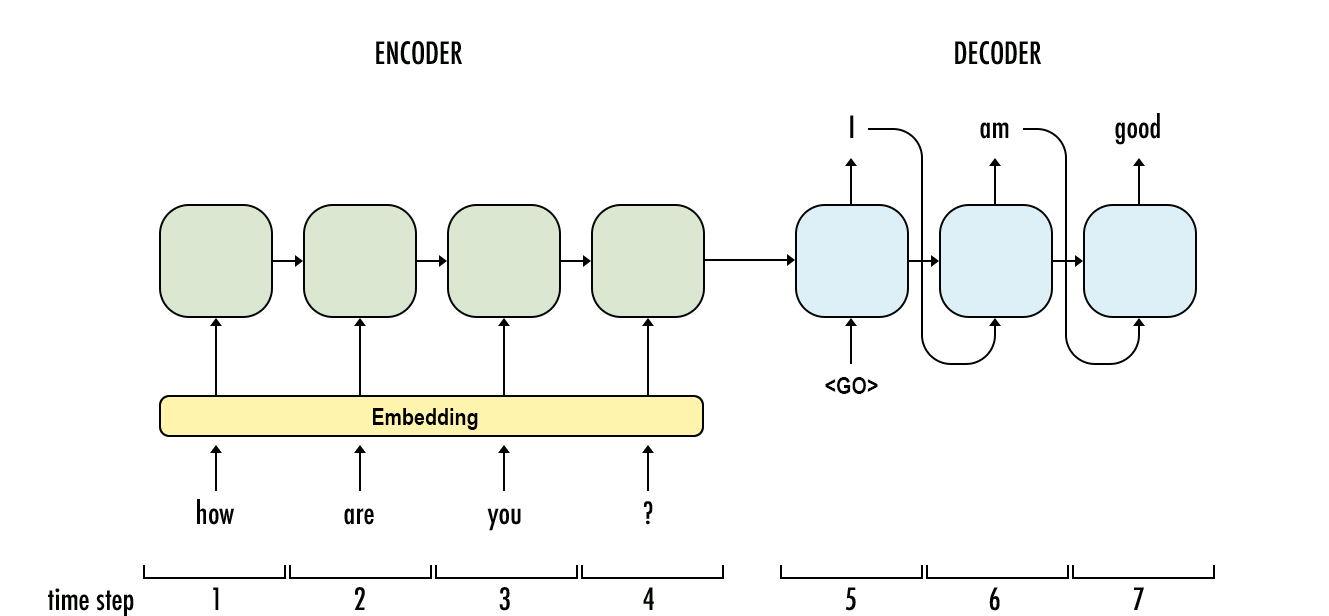

<a id="3.1"></a>
### **3.1. Encoder**

The Encoder processes the input sequence and encodes it into a context vector.


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, embed_size, hidden_size):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_size)
        outputs, hidden = self.rnn(embedded)  # outputs: (batch_size, seq_len, hidden_size)
        return hidden  # hidden: (1, batch_size, hidden_size)

<a id="3.2"></a>
### **3.2. Decoder**

The Decoder generates the target sequence one token at a time, using the context vector from the Encoder.


In [ ]:
class Decoder(nn.Module):
    def __init__(self, target_vocab_size, embed_size, hidden_size):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(target_vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, x, hidden):
        x = x.unsqueeze(1)  # (batch_size, 1)
        embedded = self.embedding(x)  # (batch_size, 1, embed_size)
        output, hidden = self.rnn(embedded, hidden)  # output: (batch_size, 1, hidden_size)
        prediction = self.fc(output.squeeze(1))  # (batch_size, target_vocab_size)
        return prediction, hidden


<a id="3.3"></a>
### **3.3. Seq2Seq Model**

The Seq2Seq model combines the Encoder and Decoder and handles the training process.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.size(0)
        target_len = target.size(1)
        target_vocab_size = self.decoder.fc.out_features

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)

        hidden = self.encoder(source)  # Get encoder hidden state

        # First input to the decoder is the <SOS> tokens
        input = target[:,0]

        for t in range(1, target_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:,t] = output
            top1 = output.argmax(1)
            input = target[:,t] if random.random() < teacher_forcing_ratio else top1
        return outputs

<a id="4"></a>
## **4. Training the Model**

We'll train the Seq2Seq model using the training data.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_vocab_size = len(input_vocab)
target_vocab_size = len(target_vocab)
embed_size = 16
hidden_size = 32
learning_rate = 0.01
num_epochs = 200

encoder = Encoder(input_vocab_size, embed_size, hidden_size).to(device)
decoder = Decoder(target_vocab_size, embed_size, hidden_size).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for src_batch, trg_input_batch, trg_output_batch in dataloader:
        src_batch = src_batch.to(device)
        trg_input_batch = trg_input_batch.to(device)
        trg_output_batch = trg_output_batch.to(device)

        optimizer.zero_grad()
        output = model(src_batch, trg_input_batch)

        output_dim = output.shape[-1]
        output = output[:,1:].reshape(-1, output_dim)
        trg_output_batch = trg_output_batch[:,1:].reshape(-1)

        loss = criterion(output, trg_output_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch+1)%20 == 0:
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

<a id="5"></a>
## **5. Testing the Model**

We'll define a function to translate new English sentences into Hebrew using the trained model.


In [ ]:
def translate(sentence):
    model.eval()
    with torch.no_grad():
        sentence = preprocess_sentence(sentence)
        sequence = sentence_to_indices(sentence, input_word2idx)
        sequence = pad_sequences([sequence], max_input_len)
        sequence = torch.tensor(sequence, dtype=torch.long).to(device)
        hidden = model.encoder(sequence)

        input_token = torch.tensor([target_word2idx['<SOS>']], dtype=torch.long).to(device)
        outputs = []
        max_len = max_target_len
        for _ in range(max_len):
            output, hidden = model.decoder(input_token, hidden)
            top1 = output.argmax(1)
            if top1.item() == target_word2idx['<EOS>']:
                break
            outputs.append(top1.item())
            input_token = top1
        translated_sentence = ' '.join([target_idx2word[idx] for idx in outputs])
    return translated_sentence

# Test the model
test_sentences = [
    'hello',
    'thank you',
    'good morning',
    'see you later',
    'i am fine'
]

for sentence in test_sentences:
    translation = translate(sentence)
    print(f'{sentence} -> {translation}')

## **6. Generating Text (Advanced)**

1.	How can this model be adapted to generate text?
2.	Try implementing a text generation function and see what you get


## **7. Conclusion**

In this notebook, we embarked on a journey to understand the fundamentals of Sequence-to-Sequence (Seq2Seq) models by building a simple English to Hebrew translator using Recurrent Neural Networks (RNNs).
Despite the simplicity and small dataset, this exercise demonstrates the fundamental concepts behind seq2seq models.


**Key Takeaways:**

- **Encoder-Decoder Architecture:**
  - The Seq2Seq model consists of two main components: the **encoder** and the **decoder**.
  - The **encoder** processes the input sequence and compresses the information into a fixed-size context vector (hidden state).
  - The **decoder** uses this context vector to generate the output sequence, word by word.
  - This architecture allows the model to handle input and output sequences of different lengths, which is essential in tasks like machine translation.

- **Handling Variable-Length Sequences:**
  - Natural language sentences vary in length, so we need a way to process them in batches.
  - We introduced special tokens:
    - `<PAD>`: Padding token to ensure all sequences in a batch are the same length.
    - `<SOS>`: Start-of-sentence token to indicate the beginning of a target sequence for the decoder.
    - `<EOS>`: End-of-sentence token to signal the end of a sequence.
  - Padding sequences allows us to leverage efficient batch processing in training.

- **Teacher Forcing:**
  - **Teacher forcing** is a training strategy where the actual target word is fed as the next input to the decoder during training.
  - It helps the model converge faster by providing the correct context at each step.
  - However, it may lead to exposure bias, where the model relies heavily on previous correct inputs and may struggle during inference when such inputs are not available.

**Model Performance and Limitations:**

- **Small Dataset Constraints:**
  - Our model was trained on a very limited dataset of 10 sentence pairs.
  - This small size restricts the model's ability to generalize to new, unseen sentences.
  - It may perform adequately on training data but poorly on unfamiliar inputs due to overfitting.
  - the decoder relies solely on the final hidden state of the encoder (the context vector).
  - This can create a bottleneck, especially for longer sentences, as the fixed-size vector may not capture all necessary information.
  - The model's performance may degrade with increasing sentence length due to loss of context.

<a id="8"></a>
## **8. Further Reading**

- [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
- [Understanding Simple Recurrent Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [PyTorch Seq2Seq Tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)